## 数据预处理

In [1]:
import os
import numpy as np
import torch
import json


# 设置随机数生成器种子
seed = 24
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


def read_classes(classes_file_path):
    """
    从classes.txt文件中读取类别列表
    Args:
        classes_file_path (str): classes.txt文件路径

    Returns:
        list: 类别列表
    """
    with open(classes_file_path, 'r') as file:
        classes = file.readline().strip().split()
    return classes


def read_labels(label_file_path, num_classes):
    """
    从label文件中读取独热码标签
    Args:
        label_file_path (str): 标签文件路径
        num_classes (int): 类别数量

    Returns:
        np.array: 独热码标签
    """
    with open(label_file_path, 'r') as file:
        line = file.readline().strip()
        labels = [int(x) for x in line.split()]
    return np.array(labels)


def load_dataset(dataset_folder):
    """
    加载多标签分类数据集
    Args:
        dataset_folder (str): 数据集文件夹路径

    Returns:
        list, list: 图像路径列表，标签列表
    """
    images_folder = os.path.join(dataset_folder, 'images')
    labels_folder = os.path.join(dataset_folder, 'labels')
    classes_file_path = os.path.join(dataset_folder, 'classes.txt')

    classes = read_classes(classes_file_path)

    image_paths = []
    labels = []

    for label_file in os.listdir(labels_folder):
        if label_file.endswith('.txt'):
            image_file = label_file.replace('.txt', '.jpg')
            image_path = os.path.join(images_folder, image_file)
            label_file_path = os.path.join(labels_folder, label_file)
            label = read_labels(label_file_path, len(classes))
            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels, classes


# print(os.getcwd())
dataset_folder = "./data/dataset_new/tongue_morphology"
image_paths, labels, classes = load_dataset(dataset_folder)
print("Number of images:", len(image_paths))
print("Number of labels:", len(labels))
print("Number of classes:", len(classes))

os.makedirs(
    "./tongue-disease-classification/tongue_morphology/best_model", exist_ok=True)
with open(
    "./tongue-disease-classification/tongue_morphology/best_model/classes.json", "w"
) as file:
    json.dump(classes, file)

Number of images: 94
Number of labels: 94
Number of classes: 3


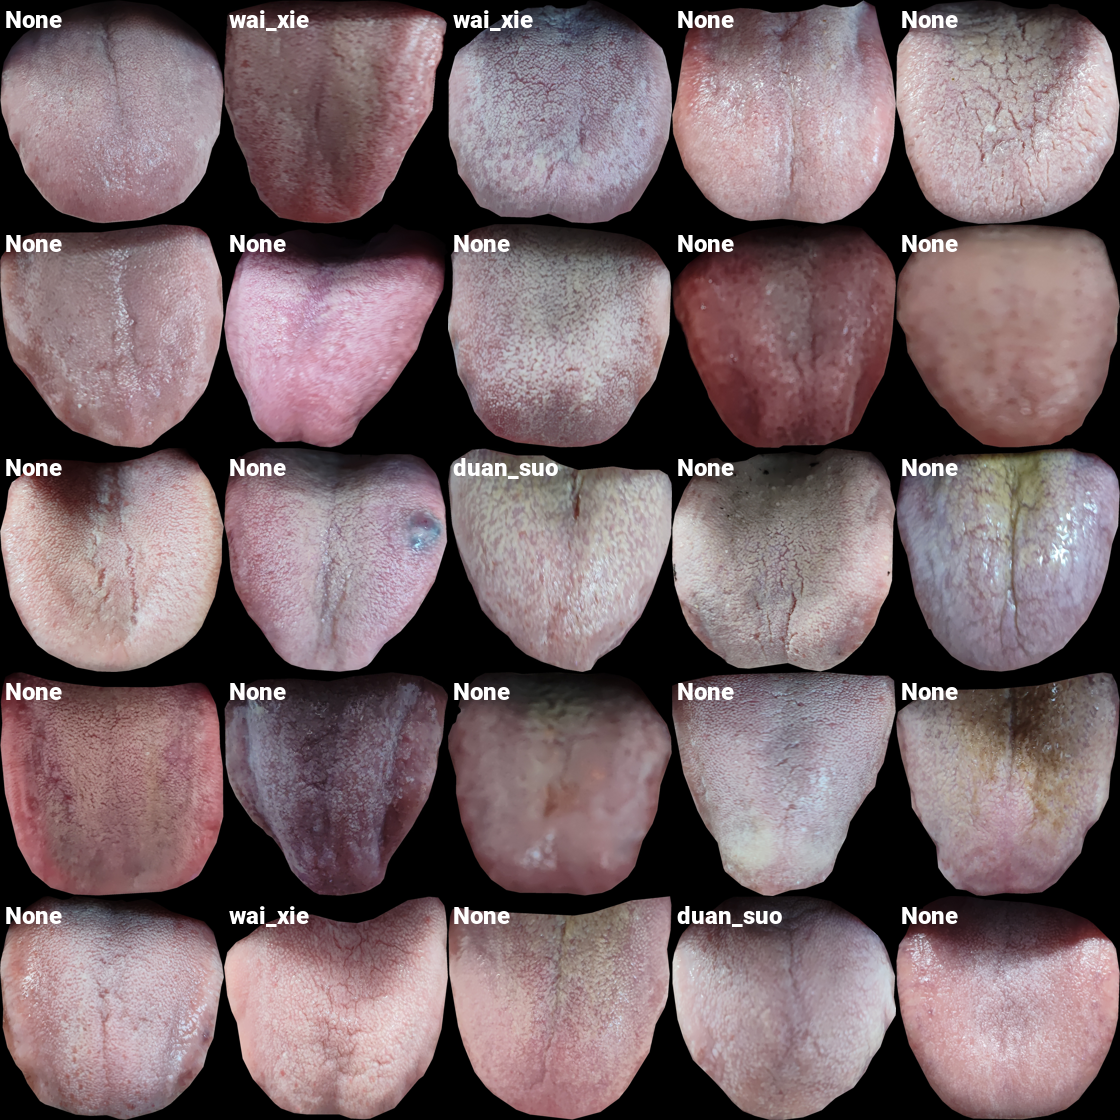

In [2]:
from PIL import Image, ImageDraw, ImageFont


def show_multi_label_examples(image_paths, labels, classes, n: int, m: int, size=(224, 224)):
    w, h = size
    num_classes = len(classes)

    # 计算每行显示的示例数量
    examples_per_row = m
    # 计算显示示例的行数
    num_rows = n
    # 计算网格图像的大小
    grid_size = (examples_per_row * w, num_rows * h)

    grid = Image.new('RGB', size=grid_size, color=(255, 255, 255))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("C:\\Users\\ChenXi\\fonts\\Roboto\\Roboto-Black.ttf", 24)

    for row in range(num_rows):
        for col in range(examples_per_row):
            idx = row * examples_per_row + col

            # 获取图片路径和对应的标签
            img_path = image_paths[idx]
            img_label = labels[idx]

            # 读取图片
            image = Image.open(img_path)

            # 读取图像的 Exif 信息，获取方向信息
            exif = image._getexif()
            orientation = exif.get(0x0112, 1) if exif else 1

            # 根据方向信息旋转图像
            if orientation == 1:
                pass
            elif orientation == 3:
                image = image.rotate(180, expand=True)
            elif orientation == 6:
                image = image.rotate(270, expand=True)
            elif orientation == 8:
                image = image.rotate(90, expand=True)

            image = image.resize(size)

            # 绘制图片
            box = (col * w, row * h)
            grid.paste(image, box=box)

            # 读取图片的标签
            label_indices = img_label
            labels_text = [classes[i] for i in range(num_classes) if label_indices[i] == 1]
            label_text = '\n'.join(labels_text) if labels_text else 'None'

            # 在图片左上角写标签
            draw.text((box[0] + 5, box[1] + 5), label_text, (255, 255, 255), font=font)

    return grid


show_multi_label_examples(image_paths, labels, classes, n=5, m=5)

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms


class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# 数据预处理和转换
dataset_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 创建数据集
dataset = MultiLabelDataset(image_paths, labels)

# 创建数据加载器
batch_size = len(dataset)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
dataloader.dataset.transform = dataset_transform
# 获取所有图像数据
all_images = None

for inputs, _ in dataloader:
    all_images = inputs

# 计算数据集的均值和标准差
mean = torch.mean(all_images, dim=(0, 2, 3))
std = torch.std(all_images, dim=(0, 2, 3))

print(f"均值：{mean}")
print(f"标准差：{std}")

均值：tensor([0.4804, 0.4054, 0.4180])
标准差：tensor([0.2915, 0.2609, 0.2682])


In [4]:
from torch.utils.data import random_split
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import TensorDataset


class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0

        mask = torch.from_numpy(mask)
        img *= mask.unsqueeze(0)

        return img
    

def binary_to_int(binary_label):
    """
    将二进制序列标签转换为一个整数

    Args:
    binary_label (np.ndarray): 二进制序列标签数组

    Returns:
    int: 转换后的整数
    """
    return int(''.join(map(str, binary_label)), 2)

def int_to_binary(number, num_bits):
    """
    将一个整数转换为对应位数的二进制序列标签

    Args:
    number (int): 要转换的整数
    num_bits (int): 二进制序列标签的位数

    Returns:
    np.ndarray: 转换后的二进制序列标签数组
    """
    binary_label = bin(number)[2:].zfill(num_bits)
    return np.array([int(bit) for bit in binary_label])


# 数据增强和预处理
data_augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomApply(transforms.GaussianBlur(3, sigma=(0.1, 2.0)), 0.5),
    Cutout(n_holes=8, length=32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# 划分数据集
train_size = int(4 / 6.0 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 划分数据集
# train_size = int(4 / 6.0 * len(dataset))
# val_size = int(1 / 6.0 * len(dataset))
# test_size = len(dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# 获取训练集的特征和标签
X_train = []
y_train = []
for inputs, labels in train_dataset:
    X_train.append(inputs.numpy())  # 将张量转换为 numpy 数组
    y_train.append(labels)
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape, len(X_train))

# 将标签转换为二进制形式
binary_labels = np.array([binary_to_int(label) for label in y_train])
# print(binary_labels)

# 创建 RandomOverSampler 实例
ros = RandomOverSampler(random_state=seed)

# 进行过采样
X_resampled, y_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), binary_labels)

# 将特征转换回张量形式
X_resampled = torch.tensor(X_resampled.reshape(-1, *inputs.shape))
y_resampled = np.array([int_to_binary(label, len(classes)) for label in y_resampled])
print("过采样后的训练集特征形状：", X_resampled.shape)
print("过采样后的训练集标签形状：", y_resampled.shape)
# print(y_resampled)

# 创建过采样后的训练集
oversampled_train_dataset = TensorDataset(X_resampled, torch.tensor(y_resampled))

(62, 3, 224, 224) (62, 3) 62
过采样后的训练集特征形状： torch.Size([188, 3, 224, 224])
过采样后的训练集标签形状： (188, 3)


In [5]:
trainloader = DataLoader(oversampled_train_dataset, batch_size=8, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
# testloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

trainloader.dataset.transform = data_augmentation_transform
valloader.dataset.transform = transform
# testloader.dataset.transform = transform

## 定义网络结构

In [6]:
import torch.nn as nn
from transformers import ViTImageProcessor, ViTModel


class VisionTransformerForMultiLabelClassification(nn.Module):
    def __init__(self, num_labels, model_name='google/vit-base-patch16-224-in21k'):
        super(VisionTransformerForMultiLabelClassification, self).__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        output = self.vit(images)
        output = self.classifier(output.pooler_output)
        output = self.sigmoid(output)
        return output
    

model_name = 'google/vit-base-patch16-224-in21k'
image_processor = ViTImageProcessor.from_pretrained(
    model_name,
    do_normalize=False,
    do_resize=False,
    do_rescale=False,
    )

## 模型训练与超参搜索

In [7]:
import torch.optim as optim
from tqdm import tqdm
import optuna
import json
import shutil


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义损失函数和优化器
criterion = nn.BCELoss()  # 二分类交叉熵损失

def objective(trial):
    # 定义超参数搜索空间
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)  # 学习率
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-1, log=True)  # 权重衰减
    num_epochs = trial.suggest_int('num_epochs', 10, 20)  # 迭代轮数
    batch_size = trial.suggest_int('batch_size', 8, 32)  # 批量大小

    # 创建超参数字典
    hyperparameters = {
        'lr': lr,
        'weight_decay': weight_decay,
        'num_epochs': num_epochs,
        'batch_size': batch_size
    }

    trainloader = DataLoader(oversampled_train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    trainloader.dataset.transform = data_augmentation_transform
    valloader.dataset.transform = transform

    # 创建模型和优化器
    model = VisionTransformerForMultiLabelClassification(num_labels=len(classes))
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = float('inf')

    # 创建当前试验的文件夹
    trial_folder = f'./tongue-disease-classification/tongue_morphology/trial_{trial.number}'
    if not os.path.exists(trial_folder):
        os.makedirs(trial_folder)
    with open(os.path.join(trial_folder, 'hyperparameters.json'), 'w') as f:
        json.dump(hyperparameters, f)

    # 训练模型
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_running_loss = 0.0
        for inputs, labels in trainloader:
            inputs = image_processor(images=inputs, return_tensors="pt").pixel_values
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())  # 将标签转换为 float 类型
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()

        # 验证模型
        model.eval()
        correct = 0
        total = 0
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                predicted = torch.round(outputs)  # 四舍五入到最近的整数，作为预测
                loss = criterion(outputs, labels.float())
                total += labels.numel()
                correct += (predicted == labels).sum().item()
                val_running_loss += loss.item()

        # 输出验证集的准确率
        accuracy = correct / total

        # 训练集损失
        train_running_loss /= len(trainloader)
        # 验证集损失
        val_running_loss /= len(valloader)

         # 输出每个epoch的平均损失
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_running_loss}, Val Loss: {val_running_loss}, Val Accuracy: {accuracy}")

        # 更新 Optuna 的试验对象
        trial.report(val_running_loss, epoch)

        # 提前停止
        if trial.should_prune():
            shutil.rmtree(trial_folder)
            raise optuna.TrialPruned()

        # 如果当前模型的验证损失更好，则保存模型
        if epoch > 5 and val_running_loss < best_val_loss:
            best_val_loss = val_running_loss
            model_path = os.path.join(trial_folder, f'best_model.pth')
            torch.save(model.state_dict(), model_path)

    # 返回验证损失作为目标函数的结果
    return best_val_loss

# 创建 Optuna 试验
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2024-05-08 13:28:44,609] A new study created in memory with name: no-name-f8ab6140-5f96-4b23-881a-cb23403a18f2
  5%|▌         | 1/20 [00:07<02:26,  7.73s/it]

Epoch 1/20, Train Loss: 0.6158012885313767, Val Loss: 0.24362035592397055, Val Accuracy: 0.9791666666666666


 10%|█         | 2/20 [00:11<01:34,  5.28s/it]

Epoch 2/20, Train Loss: 0.5676914636905377, Val Loss: 0.3202292819817861, Val Accuracy: 0.9791666666666666


 15%|█▌        | 3/20 [00:14<01:16,  4.48s/it]

Epoch 3/20, Train Loss: 0.5697434154840616, Val Loss: 0.35338370005289715, Val Accuracy: 0.9791666666666666


 20%|██        | 4/20 [00:18<01:05,  4.12s/it]

Epoch 4/20, Train Loss: 0.5756960419508127, Val Loss: 0.2746596932411194, Val Accuracy: 0.9791666666666666


 25%|██▌       | 5/20 [00:21<00:58,  3.92s/it]

Epoch 5/20, Train Loss: 0.5700767590449407, Val Loss: 0.31722329060236615, Val Accuracy: 0.9791666666666666


 30%|███       | 6/20 [00:25<00:53,  3.79s/it]

Epoch 6/20, Train Loss: 0.5639086274000314, Val Loss: 0.31297458211580914, Val Accuracy: 0.9791666666666666
Epoch 7/20, Train Loss: 0.5722784033188453, Val Loss: 0.35414983828862506, Val Accuracy: 0.9791666666666666


 35%|███▌      | 7/20 [00:29<00:49,  3.78s/it]

Epoch 8/20, Train Loss: 0.5656290237720196, Val Loss: 0.2884347240130107, Val Accuracy: 0.9791666666666666


 45%|████▌     | 9/20 [00:36<00:40,  3.70s/it]

Epoch 9/20, Train Loss: 0.5680956427867596, Val Loss: 0.3064302404721578, Val Accuracy: 0.9791666666666666


 50%|█████     | 10/20 [00:40<00:36,  3.67s/it]

Epoch 10/20, Train Loss: 0.5664148926734924, Val Loss: 0.31696172555287677, Val Accuracy: 0.9791666666666666


 55%|█████▌    | 11/20 [00:43<00:33,  3.69s/it]

Epoch 11/20, Train Loss: 0.5666296550860772, Val Loss: 0.37977396448453266, Val Accuracy: 0.9791666666666666


 60%|██████    | 12/20 [00:47<00:29,  3.65s/it]

Epoch 12/20, Train Loss: 0.567076162650035, Val Loss: 0.31892654299736023, Val Accuracy: 0.9791666666666666


 65%|██████▌   | 13/20 [00:50<00:25,  3.62s/it]

Epoch 13/20, Train Loss: 0.5640886150873624, Val Loss: 0.34392544627189636, Val Accuracy: 0.9791666666666666
Epoch 14/20, Train Loss: 0.5627150168785682, Val Loss: 0.28148211042086285, Val Accuracy: 0.9791666666666666


 75%|███████▌  | 15/20 [00:58<00:18,  3.63s/it]

Epoch 15/20, Train Loss: 0.566762584906358, Val Loss: 0.3551502029101054, Val Accuracy: 0.9791666666666666


 80%|████████  | 16/20 [01:01<00:14,  3.61s/it]

Epoch 16/20, Train Loss: 0.5678861828950735, Val Loss: 0.3081193268299103, Val Accuracy: 0.9791666666666666


 85%|████████▌ | 17/20 [01:05<00:10,  3.59s/it]

Epoch 17/20, Train Loss: 0.5632374103252704, Val Loss: 0.3086058696111043, Val Accuracy: 0.9791666666666666


 90%|█████████ | 18/20 [01:08<00:07,  3.57s/it]

Epoch 18/20, Train Loss: 0.5638345204866849, Val Loss: 0.320770929257075, Val Accuracy: 0.9791666666666666


 95%|█████████▌| 19/20 [01:12<00:03,  3.57s/it]

Epoch 19/20, Train Loss: 0.5649857314733359, Val Loss: 0.31345348556836444, Val Accuracy: 0.9791666666666666


100%|██████████| 20/20 [01:16<00:00,  3.80s/it]
[I 2024-05-08 13:30:22,929] Trial 0 finished with value: 0.28148211042086285 and parameters: {'lr': 0.0028114879891203534, 'weight_decay': 0.005566977921131258, 'num_epochs': 20, 'batch_size': 15}. Best is trial 0 with value: 0.28148211042086285.


Epoch 20/20, Train Loss: 0.5654132595429053, Val Loss: 0.31325019399325055, Val Accuracy: 0.9791666666666666


  7%|▋         | 1/15 [00:03<00:50,  3.60s/it]

Epoch 1/15, Train Loss: 0.7077882822070803, Val Loss: 0.21992526451746622, Val Accuracy: 0.9791666666666666


 13%|█▎        | 2/15 [00:07<00:46,  3.61s/it]

Epoch 2/15, Train Loss: 0.5839311927556992, Val Loss: 0.36692436536153156, Val Accuracy: 0.9791666666666666


 20%|██        | 3/15 [00:10<00:43,  3.62s/it]

Epoch 3/15, Train Loss: 0.5708117527621133, Val Loss: 0.3548974593480428, Val Accuracy: 0.9791666666666666


 27%|██▋       | 4/15 [00:14<00:39,  3.62s/it]

Epoch 4/15, Train Loss: 0.571343937090465, Val Loss: 0.2887376646200816, Val Accuracy: 0.9791666666666666


 33%|███▎      | 5/15 [00:18<00:36,  3.61s/it]

Epoch 5/15, Train Loss: 0.5728189796209335, Val Loss: 0.34385860959688824, Val Accuracy: 0.9791666666666666


 40%|████      | 6/15 [00:21<00:32,  3.61s/it]

Epoch 6/15, Train Loss: 0.5726219075066703, Val Loss: 0.28485333919525146, Val Accuracy: 0.9791666666666666
Epoch 7/15, Train Loss: 0.5726831768240247, Val Loss: 0.31722939014434814, Val Accuracy: 0.9791666666666666


 53%|█████▎    | 8/15 [00:29<00:25,  3.66s/it]

Epoch 8/15, Train Loss: 0.567525599684034, Val Loss: 0.3453885515530904, Val Accuracy: 0.9791666666666666


 60%|██████    | 9/15 [00:32<00:21,  3.64s/it]

Epoch 9/15, Train Loss: 0.568531191774777, Val Loss: 0.32729730010032654, Val Accuracy: 0.9791666666666666
Epoch 10/15, Train Loss: 0.5747897710118975, Val Loss: 0.3076375226179759, Val Accuracy: 0.9791666666666666


 73%|███████▎  | 11/15 [00:40<00:14,  3.67s/it]

Epoch 11/15, Train Loss: 0.5606661715677806, Val Loss: 0.3139864305655162, Val Accuracy: 0.9791666666666666
Epoch 12/15, Train Loss: 0.5670420612607684, Val Loss: 0.2985005776087443, Val Accuracy: 0.9791666666666666


 87%|████████▋ | 13/15 [00:47<00:07,  3.67s/it]

Epoch 13/15, Train Loss: 0.5648021740572793, Val Loss: 0.3181364834308624, Val Accuracy: 0.9791666666666666


 93%|█████████▎| 14/15 [00:51<00:03,  3.66s/it]

Epoch 14/15, Train Loss: 0.5641486772469112, Val Loss: 0.3005664646625519, Val Accuracy: 0.9791666666666666


100%|██████████| 15/15 [00:54<00:00,  3.65s/it]
[I 2024-05-08 13:31:18,418] Trial 1 finished with value: 0.2985005776087443 and parameters: {'lr': 0.0059944426363832135, 'weight_decay': 0.0030212704282442794, 'num_epochs': 15, 'batch_size': 14}. Best is trial 0 with value: 0.28148211042086285.


Epoch 15/15, Train Loss: 0.5665450074842998, Val Loss: 0.34553887446721393, Val Accuracy: 0.9791666666666666


  6%|▌         | 1/17 [00:03<00:57,  3.60s/it]

Epoch 1/17, Train Loss: 0.6117072304089864, Val Loss: 0.48529745638370514, Val Accuracy: 0.9791666666666666


 12%|█▏        | 2/17 [00:07<00:53,  3.58s/it]

Epoch 2/17, Train Loss: 0.5354786763588587, Val Loss: 0.40290287137031555, Val Accuracy: 0.9791666666666666


 18%|█▊        | 3/17 [00:10<00:50,  3.57s/it]

Epoch 3/17, Train Loss: 0.4769563948114713, Val Loss: 0.3935179114341736, Val Accuracy: 0.9791666666666666


 24%|██▎       | 4/17 [00:14<00:46,  3.57s/it]

Epoch 4/17, Train Loss: 0.44741081943114597, Val Loss: 0.3689250946044922, Val Accuracy: 0.9791666666666666


 29%|██▉       | 5/17 [00:17<00:42,  3.57s/it]

Epoch 5/17, Train Loss: 0.41869084785381955, Val Loss: 0.35931113362312317, Val Accuracy: 0.9791666666666666


 35%|███▌      | 6/17 [00:21<00:39,  3.57s/it]

Epoch 6/17, Train Loss: 0.3789428621530533, Val Loss: 0.35316066443920135, Val Accuracy: 0.9791666666666666
Epoch 7/17, Train Loss: 0.3474319130182266, Val Loss: 0.32453303039073944, Val Accuracy: 0.9791666666666666


 41%|████      | 7/17 [00:25<00:36,  3.64s/it]

Epoch 8/17, Train Loss: 0.3255160078406334, Val Loss: 0.30501891672611237, Val Accuracy: 0.9791666666666666


 53%|█████▎    | 9/17 [00:32<00:29,  3.65s/it]

Epoch 9/17, Train Loss: 0.31285271793603897, Val Loss: 0.3079516589641571, Val Accuracy: 0.9791666666666666
Epoch 10/17, Train Loss: 0.2865813771883647, Val Loss: 0.2956019639968872, Val Accuracy: 0.9791666666666666


 59%|█████▉    | 10/17 [00:36<00:25,  3.70s/it]

Epoch 11/17, Train Loss: 0.2585918555657069, Val Loss: 0.2869604080915451, Val Accuracy: 0.9791666666666666


 65%|██████▍   | 11/17 [00:40<00:22,  3.73s/it]

Epoch 12/17, Train Loss: 0.236763596534729, Val Loss: 0.2772291302680969, Val Accuracy: 0.9791666666666666


 71%|███████   | 12/17 [00:43<00:18,  3.75s/it]

Epoch 13/17, Train Loss: 0.21713509286443392, Val Loss: 0.27615174651145935, Val Accuracy: 0.9791666666666666


 76%|███████▋  | 13/17 [00:47<00:15,  3.77s/it]

Epoch 14/17, Train Loss: 0.21710077921549478, Val Loss: 0.2674468457698822, Val Accuracy: 0.9791666666666666


 82%|████████▏ | 14/17 [00:51<00:11,  3.77s/it]

Epoch 15/17, Train Loss: 0.2062551019092401, Val Loss: 0.23935748636722565, Val Accuracy: 0.9791666666666666


 94%|█████████▍| 16/17 [00:58<00:03,  3.72s/it]

Epoch 16/17, Train Loss: 0.22458106155196825, Val Loss: 0.2788692116737366, Val Accuracy: 0.96875


100%|██████████| 17/17 [01:02<00:00,  3.68s/it]
[I 2024-05-08 13:32:21,646] Trial 2 finished with value: 0.23935748636722565 and parameters: {'lr': 8.533078920831445e-05, 'weight_decay': 0.08529315339290419, 'num_epochs': 17, 'batch_size': 17}. Best is trial 2 with value: 0.23935748636722565.


Epoch 17/17, Train Loss: 0.22189159567157427, Val Loss: 0.2810535877943039, Val Accuracy: 0.90625


  7%|▋         | 1/15 [00:03<00:47,  3.37s/it]

Epoch 1/15, Train Loss: 0.5652711540460587, Val Loss: 0.36596570909023285, Val Accuracy: 0.9791666666666666


 13%|█▎        | 2/15 [00:06<00:43,  3.37s/it]

Epoch 2/15, Train Loss: 0.43224047124385834, Val Loss: 0.3195565938949585, Val Accuracy: 0.9791666666666666


 20%|██        | 3/15 [00:10<00:40,  3.36s/it]

Epoch 3/15, Train Loss: 0.3419993668794632, Val Loss: 0.30412591993808746, Val Accuracy: 0.9791666666666666


 27%|██▋       | 4/15 [00:13<00:36,  3.36s/it]

Epoch 4/15, Train Loss: 0.2687855251133442, Val Loss: 0.2940863072872162, Val Accuracy: 0.9791666666666666


 33%|███▎      | 5/15 [00:16<00:33,  3.36s/it]

Epoch 5/15, Train Loss: 0.21437427774071693, Val Loss: 0.2622550427913666, Val Accuracy: 0.9791666666666666


 40%|████      | 6/15 [00:20<00:30,  3.36s/it]

Epoch 6/15, Train Loss: 0.1692170724272728, Val Loss: 0.25729871541261673, Val Accuracy: 0.96875
Epoch 7/15, Train Loss: 0.1423191148787737, Val Loss: 0.21543367207050323, Val Accuracy: 0.9791666666666666


 47%|████▋     | 7/15 [00:23<00:27,  3.43s/it]

Epoch 8/15, Train Loss: 0.11757757794111967, Val Loss: 0.19572073966264725, Val Accuracy: 0.96875


 53%|█████▎    | 8/15 [00:27<00:24,  3.48s/it]

Epoch 9/15, Train Loss: 0.10662272945046425, Val Loss: 0.19317082315683365, Val Accuracy: 0.96875


 67%|██████▋   | 10/15 [00:34<00:17,  3.47s/it]

Epoch 10/15, Train Loss: 0.1012693289667368, Val Loss: 0.24763300269842148, Val Accuracy: 0.9583333333333334
Epoch 11/15, Train Loss: 0.09955646749585867, Val Loss: 0.16835054755210876, Val Accuracy: 0.96875


 73%|███████▎  | 11/15 [00:37<00:14,  3.51s/it]

Epoch 12/15, Train Loss: 0.08517383597791195, Val Loss: 0.14843763411045074, Val Accuracy: 0.9583333333333334


 87%|████████▋ | 13/15 [00:44<00:06,  3.48s/it]

Epoch 13/15, Train Loss: 0.08497424144297838, Val Loss: 0.17679007351398468, Val Accuracy: 0.96875


 93%|█████████▎| 14/15 [00:48<00:03,  3.45s/it]

Epoch 14/15, Train Loss: 0.2388683445751667, Val Loss: 0.2946278154850006, Val Accuracy: 0.84375


100%|██████████| 15/15 [00:51<00:00,  3.44s/it]
[I 2024-05-08 13:33:13,939] Trial 3 finished with value: 0.14843763411045074 and parameters: {'lr': 0.00015629430112599842, 'weight_decay': 0.020704844435310076, 'num_epochs': 15, 'batch_size': 24}. Best is trial 3 with value: 0.14843763411045074.


Epoch 15/15, Train Loss: 0.1440711859613657, Val Loss: 0.1680319532752037, Val Accuracy: 0.9583333333333334


  6%|▋         | 1/16 [00:03<00:53,  3.60s/it]

Epoch 1/16, Train Loss: 0.6224904576937358, Val Loss: 0.44228580594062805, Val Accuracy: 0.9791666666666666


 12%|█▎        | 2/16 [00:07<00:50,  3.58s/it]

Epoch 2/16, Train Loss: 0.5695412913958232, Val Loss: 0.3456057608127594, Val Accuracy: 0.9791666666666666


 19%|█▉        | 3/16 [00:10<00:46,  3.59s/it]

Epoch 3/16, Train Loss: 0.5916512449582417, Val Loss: 0.33671772480010986, Val Accuracy: 0.9791666666666666


 25%|██▌       | 4/16 [00:14<00:43,  3.60s/it]

Epoch 4/16, Train Loss: 0.5721008976300558, Val Loss: 0.34787218769391376, Val Accuracy: 0.9791666666666666


 31%|███▏      | 5/16 [00:17<00:39,  3.60s/it]

Epoch 5/16, Train Loss: 0.5693915247917175, Val Loss: 0.35552139083544415, Val Accuracy: 0.9791666666666666


 38%|███▊      | 6/16 [00:21<00:35,  3.60s/it]

Epoch 6/16, Train Loss: 0.5724519948164623, Val Loss: 0.3303564091523488, Val Accuracy: 0.9791666666666666
Epoch 7/16, Train Loss: 0.57418798605601, Val Loss: 0.3173779845237732, Val Accuracy: 0.9791666666666666


 44%|████▍     | 7/16 [00:25<00:33,  3.68s/it]

Epoch 8/16, Train Loss: 0.5721617897351583, Val Loss: 0.31435297926266986, Val Accuracy: 0.9791666666666666


 50%|█████     | 8/16 [00:29<00:29,  3.74s/it]

Epoch 9/16, Train Loss: 0.5938093066215515, Val Loss: 0.2748572826385498, Val Accuracy: 0.9791666666666666


 62%|██████▎   | 10/16 [00:36<00:22,  3.73s/it]

Epoch 10/16, Train Loss: 0.5846994201342265, Val Loss: 0.28932634989420575, Val Accuracy: 0.9791666666666666


 69%|██████▉   | 11/16 [00:40<00:18,  3.69s/it]

Epoch 11/16, Train Loss: 0.5752672910690307, Val Loss: 0.3160996735095978, Val Accuracy: 0.9791666666666666


 75%|███████▌  | 12/16 [00:43<00:14,  3.66s/it]

Epoch 12/16, Train Loss: 0.5691479702790578, Val Loss: 0.34418638547261554, Val Accuracy: 0.9791666666666666


 81%|████████▏ | 13/16 [00:47<00:10,  3.64s/it]

Epoch 13/16, Train Loss: 0.5660155375798543, Val Loss: 0.3191242019335429, Val Accuracy: 0.9791666666666666


 88%|████████▊ | 14/16 [00:51<00:07,  3.63s/it]

Epoch 14/16, Train Loss: 0.5653728147347769, Val Loss: 0.3308325906594594, Val Accuracy: 0.9791666666666666


 94%|█████████▍| 15/16 [00:54<00:03,  3.62s/it]

Epoch 15/16, Train Loss: 0.5679056803385417, Val Loss: 0.30745916565259296, Val Accuracy: 0.9791666666666666


100%|██████████| 16/16 [00:58<00:00,  3.65s/it]
[I 2024-05-08 13:34:13,091] Trial 4 finished with value: 0.2748572826385498 and parameters: {'lr': 0.0009407621505256995, 'weight_decay': 0.0006861043484562489, 'num_epochs': 16, 'batch_size': 13}. Best is trial 3 with value: 0.14843763411045074.


Epoch 16/16, Train Loss: 0.5657017946243286, Val Loss: 0.327446569999059, Val Accuracy: 0.9791666666666666


  6%|▌         | 1/17 [00:03<00:54,  3.41s/it]

Epoch 1/17, Train Loss: 0.49854720135529834, Val Loss: 0.24791467189788818, Val Accuracy: 0.9791666666666666


 12%|█▏        | 2/17 [00:06<00:51,  3.42s/it]

Epoch 2/17, Train Loss: 0.2456311210989952, Val Loss: 0.2213473916053772, Val Accuracy: 0.96875


 18%|█▊        | 3/17 [00:10<00:47,  3.42s/it]

Epoch 3/17, Train Loss: 0.12750965481003126, Val Loss: 0.17218536138534546, Val Accuracy: 0.9583333333333334


 24%|██▎       | 4/17 [00:13<00:44,  3.40s/it]

Epoch 4/17, Train Loss: 0.070385517552495, Val Loss: 0.10879053920507431, Val Accuracy: 0.9791666666666666


 29%|██▉       | 5/17 [00:17<00:40,  3.40s/it]

Epoch 5/17, Train Loss: 0.04220858712991079, Val Loss: 0.09734034538269043, Val Accuracy: 0.9791666666666666


 35%|███▌      | 6/17 [00:20<00:37,  3.39s/it]

Epoch 6/17, Train Loss: 0.029306448064744473, Val Loss: 0.1095116063952446, Val Accuracy: 0.96875


 41%|████      | 7/17 [00:23<00:34,  3.45s/it]

Epoch 7/17, Train Loss: 0.022124438546597958, Val Loss: 0.08332926779985428, Val Accuracy: 0.9791666666666666
Epoch 8/17, Train Loss: 0.017918279704948265, Val Loss: 0.08297485113143921, Val Accuracy: 0.96875


 47%|████▋     | 8/17 [00:27<00:31,  3.50s/it]

Epoch 9/17, Train Loss: 0.015138103937109312, Val Loss: 0.08112231642007828, Val Accuracy: 0.9791666666666666


 53%|█████▎    | 9/17 [00:31<00:28,  3.53s/it]

Epoch 10/17, Train Loss: 0.013181300523380438, Val Loss: 0.07845748960971832, Val Accuracy: 0.9791666666666666


 65%|██████▍   | 11/17 [00:38<00:20,  3.49s/it]

Epoch 11/17, Train Loss: 0.011747978162020445, Val Loss: 0.08124952018260956, Val Accuracy: 0.96875


 71%|███████   | 12/17 [00:41<00:17,  3.46s/it]

Epoch 12/17, Train Loss: 0.010690122377127409, Val Loss: 0.0796990618109703, Val Accuracy: 0.9791666666666666


 76%|███████▋  | 13/17 [00:44<00:13,  3.43s/it]

Epoch 13/17, Train Loss: 0.00980159624790152, Val Loss: 0.07931388914585114, Val Accuracy: 0.9791666666666666


 82%|████████▏ | 14/17 [00:48<00:10,  3.42s/it]

Epoch 14/17, Train Loss: 0.009079981595277786, Val Loss: 0.0800415500998497, Val Accuracy: 0.9791666666666666


 88%|████████▊ | 15/17 [00:51<00:06,  3.42s/it]

Epoch 15/17, Train Loss: 0.008468284116437038, Val Loss: 0.07861606776714325, Val Accuracy: 0.9791666666666666


 94%|█████████▍| 16/17 [00:55<00:03,  3.41s/it]

Epoch 16/17, Train Loss: 0.007937762187793851, Val Loss: 0.08076602965593338, Val Accuracy: 0.9791666666666666


100%|██████████| 17/17 [00:58<00:00,  3.44s/it]
[I 2024-05-08 13:35:12,315] Trial 5 finished with value: 0.07845748960971832 and parameters: {'lr': 0.00011452620951217816, 'weight_decay': 0.00013097245229376207, 'num_epochs': 17, 'batch_size': 32}. Best is trial 5 with value: 0.07845748960971832.


Epoch 17/17, Train Loss: 0.007461454874525468, Val Loss: 0.07994931936264038, Val Accuracy: 0.9791666666666666


  0%|          | 0/16 [00:03<?, ?it/s]
[I 2024-05-08 13:35:17,191] Trial 6 pruned. 


Epoch 1/16, Train Loss: 0.543126201345807, Val Loss: 0.39182473719120026, Val Accuracy: 0.9791666666666666


  0%|          | 0/17 [00:03<?, ?it/s]
[I 2024-05-08 13:35:21,317] Trial 7 pruned. 


Epoch 1/17, Train Loss: 0.5973332524299622, Val Loss: 0.32580162584781647, Val Accuracy: 0.9791666666666666


  0%|          | 0/10 [00:03<?, ?it/s]
[I 2024-05-08 13:35:25,882] Trial 8 pruned. 


Epoch 1/10, Train Loss: 0.5218471015493075, Val Loss: 0.32445982843637466, Val Accuracy: 0.9791666666666666


  0%|          | 0/16 [00:03<?, ?it/s]
[I 2024-05-08 13:35:29,982] Trial 9 pruned. 


Epoch 1/16, Train Loss: 0.6761010587215424, Val Loss: 0.6245001554489136, Val Accuracy: 0.7083333333333334


  0%|          | 0/12 [00:03<?, ?it/s]
[I 2024-05-08 13:35:34,164] Trial 10 pruned. 


Epoch 1/12, Train Loss: 0.5922303249438604, Val Loss: 0.3462007939815521, Val Accuracy: 0.8854166666666666


  8%|▊         | 1/13 [00:03<00:40,  3.35s/it]

Epoch 1/13, Train Loss: 0.5063200108706951, Val Loss: 0.2917419821023941, Val Accuracy: 0.9791666666666666


 15%|█▌        | 2/13 [00:06<00:36,  3.34s/it]

Epoch 2/13, Train Loss: 0.2836683839559555, Val Loss: 0.2456061989068985, Val Accuracy: 0.9791666666666666


 23%|██▎       | 3/13 [00:10<00:33,  3.34s/it]

Epoch 3/13, Train Loss: 0.17157717235386372, Val Loss: 0.21302998065948486, Val Accuracy: 0.96875


 31%|███       | 4/13 [00:13<00:30,  3.34s/it]

Epoch 4/13, Train Loss: 0.1021040054038167, Val Loss: 0.2463400736451149, Val Accuracy: 0.90625


 38%|███▊      | 5/13 [00:16<00:26,  3.34s/it]

Epoch 5/13, Train Loss: 0.06498776376247406, Val Loss: 0.16190113872289658, Val Accuracy: 0.9375


 46%|████▌     | 6/13 [00:20<00:23,  3.34s/it]

Epoch 6/13, Train Loss: 0.04084269842132926, Val Loss: 0.12588165700435638, Val Accuracy: 0.9791666666666666
Epoch 7/13, Train Loss: 0.03010002593509853, Val Loss: 0.11726058647036552, Val Accuracy: 0.96875


 62%|██████▏   | 8/13 [00:26<00:16,  3.39s/it]

Epoch 8/13, Train Loss: 0.024944619508460164, Val Loss: 0.12937889993190765, Val Accuracy: 0.96875


 69%|██████▉   | 9/13 [00:30<00:13,  3.37s/it]

Epoch 9/13, Train Loss: 0.022278882563114166, Val Loss: 0.13879814743995667, Val Accuracy: 0.96875
Epoch 10/13, Train Loss: 0.020591763546690345, Val Loss: 0.110135767608881, Val Accuracy: 0.96875


 85%|████████▍ | 11/13 [00:37<00:06,  3.41s/it]

Epoch 11/13, Train Loss: 0.019432481843978167, Val Loss: 0.12157056853175163, Val Accuracy: 0.9583333333333334


 92%|█████████▏| 12/13 [00:40<00:03,  3.39s/it]

Epoch 12/13, Train Loss: 0.01827017404139042, Val Loss: 0.12667303159832954, Val Accuracy: 0.96875
Epoch 13/13, Train Loss: 0.017352430848404765, Val Loss: 0.09091511741280556, Val Accuracy: 0.9583333333333334


100%|██████████| 13/13 [00:44<00:00,  3.39s/it]
[I 2024-05-08 13:36:19,096] Trial 11 finished with value: 0.09091511741280556 and parameters: {'lr': 0.00014535713262913588, 'weight_decay': 0.0018016839159614249, 'num_epochs': 13, 'batch_size': 25}. Best is trial 5 with value: 0.07845748960971832.
  0%|          | 0/13 [00:03<?, ?it/s]
[I 2024-05-08 13:36:23,669] Trial 12 pruned. 


Epoch 1/13, Train Loss: 0.4932647262300764, Val Loss: 0.3208839148283005, Val Accuracy: 0.875


  0%|          | 0/19 [00:03<?, ?it/s]
[I 2024-05-08 13:36:27,793] Trial 13 pruned. 


Epoch 1/19, Train Loss: 0.5237406657801734, Val Loss: 0.31487905979156494, Val Accuracy: 0.9791666666666666


  8%|▊         | 1/13 [00:03<00:40,  3.35s/it]

Epoch 1/13, Train Loss: 0.48512817706380573, Val Loss: 0.2566169202327728, Val Accuracy: 0.9791666666666666


 15%|█▌        | 2/13 [00:06<00:36,  3.34s/it]

Epoch 2/13, Train Loss: 0.24614913761615753, Val Loss: 0.3086983263492584, Val Accuracy: 0.8229166666666666


 23%|██▎       | 3/13 [00:10<00:33,  3.35s/it]

Epoch 3/13, Train Loss: 0.12803531650985991, Val Loss: 0.25534602999687195, Val Accuracy: 0.875


 31%|███       | 4/13 [00:13<00:30,  3.35s/it]

Epoch 4/13, Train Loss: 0.07412502435701233, Val Loss: 0.11505474522709846, Val Accuracy: 0.9791666666666666


 38%|███▊      | 5/13 [00:16<00:26,  3.35s/it]

Epoch 5/13, Train Loss: 0.04244417803628104, Val Loss: 0.10268660262227058, Val Accuracy: 0.96875


 46%|████▌     | 6/13 [00:20<00:23,  3.34s/it]

Epoch 6/13, Train Loss: 0.028989807569554875, Val Loss: 0.07012747041881084, Val Accuracy: 0.9791666666666666
Epoch 7/13, Train Loss: 0.02172464265355042, Val Loss: 0.07591957785189152, Val Accuracy: 0.96875


 54%|█████▍    | 7/13 [00:23<00:20,  3.41s/it]

Epoch 8/13, Train Loss: 0.01741261673825128, Val Loss: 0.06443031691014767, Val Accuracy: 0.9791666666666666


 62%|██████▏   | 8/13 [00:27<00:17,  3.47s/it]

Epoch 9/13, Train Loss: 0.014630522978092943, Val Loss: 0.06236170697957277, Val Accuracy: 0.9791666666666666


 77%|███████▋  | 10/13 [00:34<00:10,  3.46s/it]

Epoch 10/13, Train Loss: 0.012753897346556187, Val Loss: 0.0627557709813118, Val Accuracy: 0.9791666666666666
Epoch 11/13, Train Loss: 0.011362293735146523, Val Loss: 0.05991439148783684, Val Accuracy: 0.9791666666666666


 92%|█████████▏| 12/13 [00:41<00:03,  3.45s/it]

Epoch 12/13, Train Loss: 0.01027759417359318, Val Loss: 0.0603310726583004, Val Accuracy: 0.9791666666666666
Epoch 13/13, Train Loss: 0.009414538741111755, Val Loss: 0.05836845934391022, Val Accuracy: 0.9791666666666666


100%|██████████| 13/13 [00:44<00:00,  3.44s/it]
[I 2024-05-08 13:37:13,222] Trial 14 finished with value: 0.05836845934391022 and parameters: {'lr': 0.00010963721404781221, 'weight_decay': 0.0001062998873912592, 'num_epochs': 13, 'batch_size': 29}. Best is trial 14 with value: 0.05836845934391022.
  9%|▉         | 1/11 [00:03<00:34,  3.46s/it]

Epoch 1/11, Train Loss: 0.5827685381684985, Val Loss: 0.23557620495557785, Val Accuracy: 0.9791666666666666


 18%|█▊        | 2/11 [00:06<00:30,  3.39s/it]

Epoch 2/11, Train Loss: 0.5132796125752586, Val Loss: 0.413243904709816, Val Accuracy: 0.8854166666666666


 27%|██▋       | 3/11 [00:10<00:26,  3.37s/it]

Epoch 3/11, Train Loss: 0.2632308453321457, Val Loss: 0.2684529200196266, Val Accuracy: 0.8541666666666666


 36%|███▋      | 4/11 [00:13<00:23,  3.36s/it]

Epoch 4/11, Train Loss: 0.16818892530032567, Val Loss: 0.6603378057479858, Val Accuracy: 0.71875


 45%|████▌     | 5/11 [00:16<00:20,  3.36s/it]

Epoch 5/11, Train Loss: 0.1141139944749219, Val Loss: 0.18260864168405533, Val Accuracy: 0.9270833333333334


 55%|█████▍    | 6/11 [00:20<00:16,  3.36s/it]

Epoch 6/11, Train Loss: 0.07345243224075862, Val Loss: 0.19536157697439194, Val Accuracy: 0.9270833333333334
Epoch 7/11, Train Loss: 0.031238165018813952, Val Loss: 0.10216897632926702, Val Accuracy: 0.9583333333333334


 64%|██████▎   | 7/11 [00:23<00:13,  3.42s/it]

Epoch 8/11, Train Loss: 0.06415292540831226, Val Loss: 0.09871477819979191, Val Accuracy: 0.9583333333333334


 82%|████████▏ | 9/11 [00:30<00:06,  3.43s/it]

Epoch 9/11, Train Loss: 0.033201539888978004, Val Loss: 0.16756044048815966, Val Accuracy: 0.90625


 91%|█████████ | 10/11 [00:34<00:03,  3.41s/it]

Epoch 10/11, Train Loss: 0.030066984506057843, Val Loss: 0.15650309436023235, Val Accuracy: 0.9270833333333334
Epoch 11/11, Train Loss: 0.016738507830138718, Val Loss: 0.07500100554898381, Val Accuracy: 0.96875


100%|██████████| 11/11 [00:37<00:00,  3.42s/it]
[I 2024-05-08 13:37:52,339] Trial 15 finished with value: 0.07500100554898381 and parameters: {'lr': 0.0006068095706365, 'weight_decay': 0.00010267792035732934, 'num_epochs': 11, 'batch_size': 29}. Best is trial 14 with value: 0.05836845934391022.
  0%|          | 0/10 [00:03<?, ?it/s]
[I 2024-05-08 13:37:57,067] Trial 16 pruned. 


Epoch 1/10, Train Loss: 0.5837582520076207, Val Loss: 0.25891944020986557, Val Accuracy: 0.9791666666666666


  0%|          | 0/12 [00:03<?, ?it/s]
[I 2024-05-08 13:38:01,891] Trial 17 pruned. 


Epoch 1/12, Train Loss: 0.6015293233924441, Val Loss: 0.33478376269340515, Val Accuracy: 0.9791666666666666


  0%|          | 0/11 [00:03<?, ?it/s]
[I 2024-05-08 13:38:06,111] Trial 18 pruned. 


Epoch 1/11, Train Loss: 0.5049991011619568, Val Loss: 0.4402488023042679, Val Accuracy: 0.7604166666666666


  0%|          | 0/13 [00:03<?, ?it/s]
[I 2024-05-08 13:38:10,736] Trial 19 pruned. 


Epoch 1/13, Train Loss: 0.5232836306095123, Val Loss: 0.2876124083995819, Val Accuracy: 0.9791666666666666


## 模型推理

In [ ]:
infer_model = VisionTransformerForMultiLabelClassification(num_labels=len(classes))
infer_model.load_state_dict(torch.load(
    './tongue-disease-classification/tongue_morphology/best_model/best_model.pth'))
infer_model.to(device)

infer_image_processor = ViTImageProcessor.from_pretrained(model_name)

def predict_image_class(image_path, model, image_processor, classes):
    image = Image.open(image_path).convert("RGB")
    inputs = image_processor(images=image, return_tensors="pt").pixel_values
    inputs = inputs.to(device)
    outputs = model(inputs)
    predicted = torch.round(outputs)
    predicted = predicted.cpu().detach().numpy().astype(int).flatten()
    if 1 not in predicted:
        return ['None']
    predicted_classes = [classes[i] for i in range(len(classes)) if predicted[i] == 1]
    return predicted_classes


# test_image_path = "./data/test/seg_dataset/test1.jpg"
# test_image_path = r"data\dataset_new\coating_state\images\tongue_front_300126157003 _2023-11-07-11-07-19.jpg"
# test_image_path = r"data\dataset_new\coating_state\images\tongue_front_300137245001_2023-10-26-15-27-53.jpg"
test_image_path = r"data\dataset_new\coating_state\images\tongue_front_300136428001_2023-10-24-10-46-33.jpg"
predict_image_class(test_image_path, infer_model, infer_image_processor, classes)